### Install SECANT from GitHub
##### - Before running, make sure runtime has been set to GPU

In [ ]:
!pip install git+https://github.com/tarot0410/SECANT.git -q
!pip install umap-learn

     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 1.2MB 27.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=85cc846b316ff241c42e9d658242e1958c9bc4f5380b9b5668b0a96b17608dcc
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=1f92f05f293999c0d00bd546272f15002ab9c65518cb212fc5e7f0c67c1e8175
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


### Import packages

In [ ]:
from SECANT import SECANT as SE
import torch
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import time

### Mount Google Drive for accessing external data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Analyzing human bone marrow data (a subset of 10,000 cells from data in Seurat package)

In [ ]:
### Load in ADT confident cell type label
url = 'https://raw.githubusercontent.com/tarot0410/SECANT/main/real_data/Bone_marrow/'
ADT_df = pd.read_csv(url + 'label_bm_sub.csv')
ADT_Lbl = SE.df_to_tensor(ADT_df)[:,0]   
ADT_Lbl = ADT_Lbl - 1 # make sure values in ADT_Lbl range from 0, and the maximum value refers to "uncertain" group
# Check uncertain rate in the given ADT label
print('P(uncertain)=', round(sum(ADT_Lbl.cpu().numpy()==int(torch.max(ADT_Lbl)))/ADT_Lbl.size(0),3))

# Load in RNA data (after dimension reduction)
RNA_df0 = pd.read_csv(url + 'bm_latent_D10_sub.csv')
RNA_df0.drop(RNA_df0.columns[[0]], axis=1, inplace=True) # drop index column
data0 = SE.df_to_tensor(RNA_df0) # convert data matrix df to tensor
print('#cells=', data0.size(0))
print('#features=', data0.size(1))

P(uncertain)= 0.205
#cells= 10000
#features= 10


### UMAP for visualization (ADT confident cell types)

In [ ]:
# Set up UMAP
reducer = umap.UMAP(random_state=50)
embedding0 = reducer.fit_transform(data0.cpu())

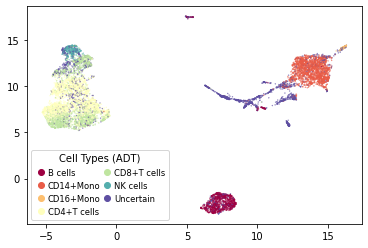

In [ ]:
# Colored by ADT confident cell types
scatter0 = plt.scatter(embedding0[:, 0],
           embedding0[:, 1],
           c=ADT_Lbl.cpu().numpy(), s=0.1, cmap='Spectral')
mylabel0=('B cells', 'CD14+Mono', 'CD16+Mono', 'CD4+T cells','CD8+T cells','NK cells', 'Uncertain')
legend0 = plt.legend(handles=scatter0.legend_elements()[0], labels=mylabel0, loc="best", title="Cell Types (ADT)", fontsize="small", ncol=2, columnspacing = 0.01, handlelength =1.5, handletextpad =0.1)

### Run SECANT

In [ ]:
### Input one configuration of concordance matrix
# Example: {B:4; CD14+ Mono:3; CD16+ Mono: 1; CD4+ T:2; CD8+ T:2; NK:1}
# Determine based on prior knowledge or data-driven (check 'Search_Best_Config' section)
concordance_config = [4,3,1,2,2,1]

### Main function to run SECANT
startTime = time.perf_counter()
SE_rslt = SE.SECANT_CITE(data0, concordance_config, ADT_Lbl)
print('running time {}'.format(time.perf_counter()-startTime)) 

### Core outputs
# cluster labels
lbl_out = SE_rslt.lbl
# concordance matrix
conMtxFinal = SE_rslt.conMtxFinal 
# cluster weights
wgt_out = SE_rslt.wgt_out
# final converged log-likelihood
logLik_final = SE_rslt.logLik_final 

### Estimated distribution parameters
# cluster-specific mean vector
mu_out = SE_rslt.mu_out
# cluster-specific covariance matrix
scale_out = SE_rslt.scale3D_out
scale_out_t = scale_out.permute(0,2,1)
cov_out = scale_out @ scale_out_t

running time 4.079390727000003


### Check SECANT results

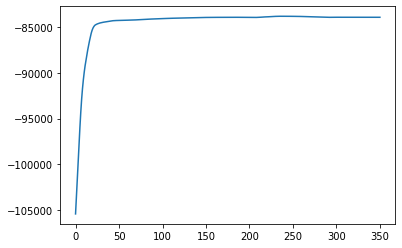

In [ ]:
### Check convergence of log-likelihoods
# log-likelihoods across all iterations
logLik_vec = SE_rslt.logLikVec 
logLik_vec_final = logLik_vec[logLik_vec != 0] 
plt.plot(logLik_vec_final)

In [ ]:
### Concordance matrix and cluster weights
print('Concordance matrix:')
print(np.around(conMtxFinal.cpu().data.numpy(),3))
print('')
print('Cluster weights:')
print(np.around(wgt_out.cpu().data.numpy(),3))

Concordance matrix:
[[0.859 0.248 0.921 0.082 0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.22  0.513 0.97  0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.63  0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.949 0.898 0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.706 0.958
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.759]
 [0.141 0.752 0.079 0.918 0.78  0.487 0.03  0.37  0.051 0.102 0.294 0.042
  0.241]]

Cluster weights:
[0.054 0.026 0.061 0.056 0.044 0.038 0.178 0.015 0.159 0.117 0.086 0.122
 0.044]


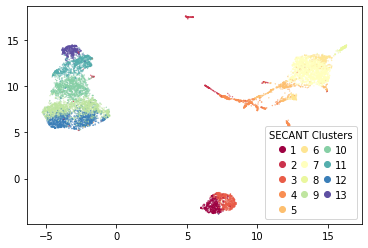

In [ ]:
### Visualization of SECANT cluster
se_lbl = lbl_out.cpu().data.numpy()
scatter1 = plt.scatter(embedding0[:, 0],
                       embedding0[:, 1],
                       c=se_lbl, s=0.1, cmap='Spectral')
mylabel1 = range(1, len(np.unique(se_lbl))+1)
legend1 = plt.legend(handles=scatter1.legend_elements(num=None)[0], labels=mylabel1, loc="best", title="SECANT Clusters", fontsize="medium", columnspacing = 0.01, handlelength =1.5, handletextpad =0.1, ncol=3)